研讨课内容：
1. 评估函数
2. keras 实现TextCNN 多分类
3. keras 实现TextCNN 多标签分类

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import re
import sys
sys.path.append('/root/project/kaikeba/project02/code')
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf
tf.__version__

'2.0.0'

# 0. 加载数据

In [5]:
root='data/baidu_95.csv'
df = pd.read_csv(root,header=None).rename(columns={0:'label',1:'content'})
df.head()

,label,content
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜从土壤中吸收的氮元素可以用来合成（）A.淀粉和纤维素B.葡萄糖和DNAC.核酸和蛋白质D...
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列有关生物体内信息传递的叙述，正确的是（）A下丘脑分泌的促甲状腺激素释放激素，可作用于甲状...
2,高中 生物 生物技术实践 生物工程技术,从自然菌样筛选较理想生产菌种的一般步骤是：采集菌样→富集培养→纯种分离→性能测定．1.不同微...
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前，精子载体法逐渐成为具有诱惑力的制备转基因动物方法之一，该方法以精子作为外源基因的载体，...
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人想乘普通飞机在一年中连续过两次生日，你认为应穿越（）A赤道B两级C本初子午线D国际日期变更线


# 1.数据处理

## 加载停用词

In [7]:
def load_stop_words(stop_word_path):
    '''
    加载停用词
    :param stop_word_path:停用词路径
    :return: 停用词表 list
    '''
    # 打开文件
    file = open(stop_word_path, 'r', encoding='utf-8')
    # 读取所有行
    stop_words = file.readlines()
    # 去除每一个停用词前后 空格 换行符
    stop_words = [stop_word.strip() for stop_word in stop_words]
    return stop_words

## 过滤字符

In [8]:
def clean_sentence(line):
    line = re.sub(
            "[a-zA-Z0-9]|[\s+\-\|\!\/\[\]\{\}_,.$%^*(+\"\')]+|[:：+——()?【】《》“”！，。？、~@#￥%……&*（）]+|题目", '',line)
    words = jieba.cut(line, cut_all=False)
    return words

In [9]:
stopwords_path='data/stopwords/哈工大停用词表.txt'
stop_words=load_stop_words(stopwords_path)

def sentence_proc(sentence):
    '''
    预处理模块
    :param sentence:待处理字符串
    :return: 处理后的字符串
    '''
    # 清除无用词
    words = clean_sentence(sentence)
    # 过滤停用词
    words = [word for word in words if word not in stop_words]
    # 拼接成一个字符串,按空格分隔
    return ' '.join(words)

def proc(df):
    df['content']=df['content'].apply(sentence_proc)
    return df

# 并行处理

In [10]:
from utils.multi_proc_utils import parallelize

In [11]:
%%time
df=parallelize(df,proc)

Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cac

CPU times: user 199 ms, sys: 265 ms, total: 464 ms
Wall time: 3.08 s


In [12]:
df.head()

,label,content
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...
2,高中 生物 生物技术实践 生物工程技术,自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...


# 2. Vocab

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

In [14]:
vocab_size=30000
padding_size=200

# ids

In [15]:
text_preprocesser = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
text_preprocesser.fit_on_texts(df['content'])
x = text_preprocesser.texts_to_sequences(df['content'])
word_dict = text_preprocesser.word_index

# 3. Padding

In [16]:
x = pad_sequences(x, maxlen=padding_size,padding='post', truncating='post')

In [17]:
x

array([[3396,  402,    2, ...,    0,    0,    0],
       [   4,  400,   28, ...,    0,    0,    0],
       [ 254, 8779,  368, ...,    0,    0,    0],
       ...,
       [  38, 2493,   12, ...,    0,    0,    0],
       [   4,   11,   39, ...,    0,    0,    0],
       [ 576,   38, 1904, ...,    0,    0,    0]], dtype=int32)

# 4. 多分类

多分类与多标签分类label的处理方式不同

## 数据处理

我们使用subject作为label，content作为data进行分类。

In [18]:
df['subject']=df['label'].apply(lambda x:x.split()[1])
df.head()

,label,content,subject
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸,生物
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...,生物
2,高中 生物 生物技术实践 生物工程技术,自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...,生物
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...,生物
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...,地理


In [19]:
df.describe()

,label,content,subject
count,22576,22576,22576
unique,673,18114,4
top,高中 地理 宇宙中的地球 地球运动的地理意义,下列 四幅 图中能 正确 表示 地球 自转 方向,生物
freq,1533,21,13285


In [20]:
set(df['subject'])

{'历史', '地理', '政治', '生物'}

## 编码

In [23]:
from sklearn.preprocessing import LabelBinarizer

In [24]:
lb=LabelBinarizer()
lb.fit(df['subject'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [25]:
y=lb.transform(df['subject'])

In [26]:
y

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [27]:
len(y[0])

4

In [28]:
y[0]

array([0, 0, 0, 1])

# 数据集划分

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [32]:
len(X_train[1])

200

# 1. TextCNN

# 模型结构

![](data/img/model.png)

## TextCNN详细过程：

+ Embedding：第一层是图中最左边的7乘5的句子矩阵，每行是词向量，维度=5，这个可以类比为图像中的原始像素点。
+ Convolution：然后经过 kernel_sizes=(2,3,4) 的一维卷积层，每个kernel_size 有两个输出 channel。
+ MaxPolling：第三层是一个1-max pooling层，这样不同长度句子经过pooling层之后都能变成定长的表示。
+ FullConnection and Softmax：最后接一层全连接的 softmax 层，输出每个类别的概率。


## 通道（Channels）：

+ 图像中可以利用 (R, G, B) 作为不同channel；
+ 文本的输入的channel通常是不同方式的embedding方式（比如 word2vec或Glove），实践中也有利用静态词向量和fine-tunning词向量作为不同channel的做法。
 

## 一维卷积（conv-1d）：

+ 图像是二维数据；
+ 文本是一维数据，因此在TextCNN卷积用的是一维卷积（在word-level上是一维卷积；虽然文本经过词向量表达后是二维数据，但是在embedding-level上的二维卷积没有意义）。一维卷积带来的问题是需要通过设计不同 kernel_size 的 filter 获取不同宽度的视野。

# 特征：这里用的是词向量表示方式

+ 数据量较大：可以直接随机初始化embeddings，然后基于语料通过训练模型网络来对embeddings进行更新和学习。
+ 数据量较小：可以利用外部语料来预训练(pre-train)词向量，然后输入到Embedding层，用预训练的词向量矩阵初始化embeddings。（通过设置weights=[embedding_matrix]）。
+ 静态(static)方式：训练过程中不再更新embeddings。实质上属于迁移学习，特别是在目标领域数据量比较小的情况下，采用静态的词向量效果也不错。（通过设置trainable=False）
+ 非静态(non-static)方式：在训练过程中对embeddings进行更新和微调(fine tune)，能加速收敛。（通过设置trainable=True）

![](data/img/conv1D.png)

In [34]:
import logging
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten, concatenate, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from pprint import pprint
from utils.metrics import micro_f1,macro_f1

def TextCNN(max_sequence_length, max_token_num, embedding_dim, output_dim, model_img_path=None, embedding_matrix=None):
    """
    TextCNN: 
    1.embedding layers, 
    2.convolution layer, 
    3.max-pooling, 
    4.softmax layer. 
    """
    
    x_input = Input(shape=(max_sequence_length,))
    logging.info("x_input.shape: %s" % str(x_input.shape))  # (?, 60)

    if embedding_matrix is None:
        x_emb = Embedding(input_dim=max_token_num, output_dim=embedding_dim, input_length=max_sequence_length)(x_input)
    else:
        x_emb = Embedding(input_dim=max_token_num, output_dim=embedding_dim, input_length=max_sequence_length,
                          weights=[embedding_matrix], trainable=True)(x_input)
    
    logging.info("x_emb.shape: %s" % str(x_emb.shape))  # (?, 60, 300)

    pool_output = []
    kernel_sizes = [2, 3, 4] 
    for kernel_size in kernel_sizes:
        c = Conv1D(filters=2, kernel_size=kernel_size, strides=1)(x_emb)
        p = MaxPool1D(pool_size=int(c.shape[1]))(c)
        pool_output.append(p)
        logging.info("kernel_size: %s \t c.shape: %s \t p.shape: %s" % (kernel_size, str(c.shape), str(p.shape)))
    
    pool_output = concatenate([p for p in pool_output])
    logging.info("pool_output.shape: %s" % str(pool_output.shape))  # (?, 1, 6)

    x_flatten = Flatten()(pool_output)  # (?, 6)
    y = Dense(output_dim, activation='softmax')(x_flatten)  # (?, 2)
    
    logging.info("y.shape: %s \n" % str(y.shape))

    model = Model([x_input], outputs=[y])
    
    if model_img_path:
        plot_model(model, to_file=model_img_path, show_shapes=True, show_layer_names=False)
    model.summary()
    
    return model

# 参数设置

In [35]:
feature_size=padding_size
embed_size=300
num_classes=len(y[0])
filter_sizes='3,4,5'
dropout_rate=0.5
regularizers_lambda=0.01
learning_rate=0.01
batch_size=512
epochs=5

![](data/img/model.png)

# TextRNN
# TextCNN

In [36]:
model=TextCNN(max_sequence_length=feature_size, max_token_num=vocab_size, embedding_dim=embed_size, output_dim=num_classes)
model.compile(tf.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy',
              metrics=[micro_f1, macro_f1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 199, 2)       1202        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 2)       1802        embedding[0][0]                  
______________________________________________________________________________________________

In [37]:
print('Train...')
early_stopping = EarlyStopping(monitor='val_micro_f1', patience=10, mode='max')

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          workers=32,
          use_multiprocessing=True,
          callbacks=[early_stopping],
          validation_data=(X_test, y_test))

Train...
Train on 18060 samples, validate on 4516 samples
Epoch 1/5
18060/18060 [==============================] - 8s 445us/sample - loss: 0.4019 - micro_f1: 0.7830 - macro_f1: 0.6757 - val_loss: 0.0511 - val_micro_f1: 0.9841 - val_macro_f1: 0.9716
Epoch 2/5
18060/18060 [==============================] - 4s 249us/sample - loss: 0.0134 - micro_f1: 0.9971 - macro_f1: 0.9951 - val_loss: 0.0402 - val_micro_f1: 0.9880 - val_macro_f1: 0.9775
Epoch 3/5
18060/18060 [==============================] - 5s 257us/sample - loss: 0.0010 - micro_f1: 0.9999 - macro_f1: 0.9999 - val_loss: 0.0421 - val_micro_f1: 0.9882 - val_macro_f1: 0.9779
Epoch 4/5
18060/18060 [==============================] - 5s 261us/sample - loss: 2.5985e-04 - micro_f1: 1.0000 - macro_f1: 1.0000 - val_loss: 0.0414 - val_micro_f1: 0.9884 - val_macro_f1: 0.9786
Epoch 5/5
18060/18060 [==============================] - 4s 246us/sample - loss: 1.4613e-04 - micro_f1: 1.0000 - macro_f1: 1.0000 - val_loss: 0.0405 - val_micro_f1: 0.9886 - 

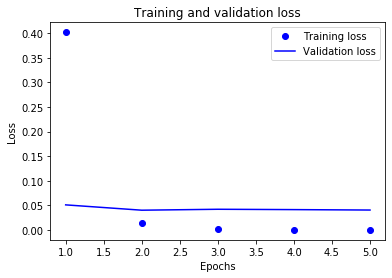

In [38]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

micro_f1 = history_dict['micro_f1']
val_micro_f1 = history_dict['val_micro_f1']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(micro_f1) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

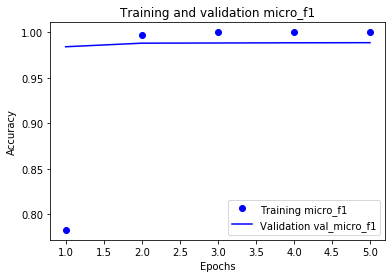

In [39]:
plt.clf()   # 清除数字

plt.plot(epochs, micro_f1, 'bo', label='Training micro_f1')
plt.plot(epochs, val_micro_f1, 'b', label='Validation val_micro_f1')
plt.title('Training and validation micro_f1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 预测

In [40]:
from utils.plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix

In [41]:
y_pred=model.predict(X_test)

In [42]:
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

In [44]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       516
           1       0.98      0.99      0.98       943
           2       0.98      0.97      0.97       393
           3       1.00      1.00      1.00      2664

    accuracy                           0.99      4516
   macro avg       0.98      0.98      0.98      4516
weighted avg       0.99      0.99      0.99      4516



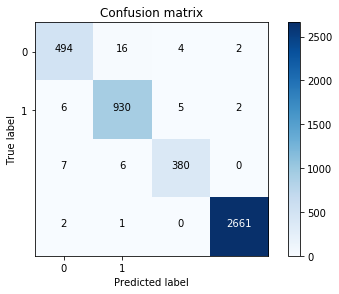

In [45]:
# 计算混淆矩阵
conf_mat=confusion_matrix(y_true,y_pred)
# 画混淆矩阵
plot_confusion_matrix(conf_mat,classes=[0,1])

# 2. 多标签分类

In [48]:
df.head()

,label,content,subject
0,"[高中, 生物, 分子与细胞, 组成细胞的化学元素, 组成细胞的化合物]",菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸,生物
1,"[高中, 生物, 稳态与环境, 神经调节和体液调节的比较]",下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...,生物
2,"[高中, 生物, 生物技术实践, 生物工程技术]",自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...,生物
3,"[高中, 生物, 生物技术实践, 生物技术在其他方面的应用, 器官移植, 复等位基因, 胚胎...",目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...,生物
4,"[高中, 地理, 宇宙中的地球, 地球运动的地理意义]",某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...,地理


In [47]:
df['label']=df['label'].apply(lambda x:x.split())

In [50]:
mlb = MultiLabelBinarizer()

In [52]:
mlb = mlb.fit(df['label'])

In [53]:
y = mlb.fit_transform(df['label'])

In [55]:
len(y[0])

95

In [56]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0])

# 划分数据集

In [60]:
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

# 参数设置

In [70]:
feature_size=padding_size
embed_size=300
num_classes=len(y[0])
filter_sizes='3,4,5'
dropout_rate=0.5
regularizers_lambda=0.01
learning_rate=0.01
batch_size=512
epochs=10

# 模型修改

![](data/img/conv1D.png)

In [62]:
import logging
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten, concatenate, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from pprint import pprint

def TextCNN(max_sequence_length, max_token_num, embedding_dim, output_dim, model_img_path=None, embedding_matrix=None):
    """
    TextCNN: 
    1. embedding layers, 
    2.convolution layer, 
    3.max-pooling, 
    4.softmax layer. 
    """
    
    x_input = Input(shape=(max_sequence_length,))
    logging.info("x_input.shape: %s" % str(x_input.shape))  # (?, 60)

    if embedding_matrix is None:
        x_emb = Embedding(input_dim=max_token_num, output_dim=embedding_dim, input_length=max_sequence_length)(x_input)
    else:
        x_emb = Embedding(input_dim=max_token_num, output_dim=embedding_dim, input_length=max_sequence_length,
                          weights=[embedding_matrix], trainable=True)(x_input)
    
    logging.info("x_emb.shape: %s" % str(x_emb.shape))  # (?, 60, 300)

    pool_output = []
    kernel_sizes = [2, 3, 4] 
    for kernel_size in kernel_sizes:
        c = Conv1D(filters=2, kernel_size=kernel_size, strides=1)(x_emb)
        p = MaxPool1D(pool_size=int(c.shape[1]))(c)
        pool_output.append(p)
        logging.info("kernel_size: %s \t c.shape: %s \t p.shape: %s" % (kernel_size, str(c.shape), str(p.shape)))
    
    pool_output = concatenate([p for p in pool_output])
    logging.info("pool_output.shape: %s" % str(pool_output.shape))  # (?, 1, 6)

    x_flatten = Flatten()(pool_output)  # (?, 6)
    y = Dense(output_dim, activation='sigmoid')(x_flatten)  # (?, 2)
    
    logging.info("y.shape: %s \n" % str(y.shape))

    model = Model([x_input], outputs=[y])
    
    if model_img_path:
        plot_model(model, to_file=model_img_path, show_shapes=True, show_layer_names=False)
    model.summary()
    
    return model

In [65]:
from utils.metrics import micro_f1, macro_f1

In [71]:
model=TextCNN(max_sequence_length=feature_size, max_token_num=vocab_size, embedding_dim=embed_size, output_dim=num_classes)

model.compile(tf.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=[micro_f1, macro_f1])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     9000000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 199, 2)       1202        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 198, 2)       1802        embedding_5[0][0]                
____________________________________________________________________________________________

In [72]:
print('Train...')
early_stopping = EarlyStopping(monitor='val_micro_f1', patience=10, mode='max')

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          workers=32,
          use_multiprocessing=True,
          callbacks=[early_stopping],
          validation_data=(X_test, y_test))

Train...
Train on 18060 samples, validate on 4516 samples
Epoch 1/10
18060/18060 [==============================] - 6s 333us/sample - loss: 0.2959 - micro_f1: 0.3243 - macro_f1: 0.0254 - val_loss: 0.1733 - val_micro_f1: 0.4042 - val_macro_f1: 0.0190
Epoch 2/10
18060/18060 [==============================] - 5s 262us/sample - loss: 0.1562 - micro_f1: 0.4477 - macro_f1: 0.0382 - val_loss: 0.1316 - val_micro_f1: 0.5142 - val_macro_f1: 0.0761
Epoch 3/10
18060/18060 [==============================] - 5s 254us/sample - loss: 0.1086 - micro_f1: 0.6181 - macro_f1: 0.1504 - val_loss: 0.0917 - val_micro_f1: 0.6911 - val_macro_f1: 0.2462
Epoch 4/10
18060/18060 [==============================] - 5s 266us/sample - loss: 0.0800 - micro_f1: 0.7426 - macro_f1: 0.3371 - val_loss: 0.0776 - val_micro_f1: 0.7570 - val_macro_f1: 0.3571
Epoch 5/10
18060/18060 [==============================] - 5s 252us/sample - loss: 0.0654 - micro_f1: 0.7983 - macro_f1: 0.4420 - val_loss: 0.0715 - val_micro_f1: 0.7850 - val

# 预测

In [73]:
y_pred=model.predict(X_test)

In [74]:
y_pred

array([[8.1926584e-05, 8.9406967e-08, 0.0000000e+00, ..., 1.9222498e-05,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0582805e-04, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 7.1555525e-02, 1.3411045e-06, ..., 0.0000000e+00,
        1.0000000e+00, 2.9802322e-08],
       ...,
       [2.9802322e-08, 3.6665797e-04, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.7888737e-02, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.6760260e-02, 5.9604645e-08, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
np.argmax(y_pred,axis=1)

In [75]:
y_pred = np.where(y_pred>0.5,1,0)

In [76]:
from sklearn.metrics import f1_score,accuracy_score

In [77]:
f1_score(y_test,y_pred,average='samples')

0.7958356732713625

In [78]:
mlb.inverse_transform(y_pred)

[('地理', '宇宙中的地球', '高中'),
 ('公民道德与伦理常识', '劳动就业与守法经营', '政治', '社会主义市场经济的伦理要求', '高中'),
 ('人工授精、试管婴儿等生殖技术', '生物', '生物性污染', '生物科学与社会', '避孕的原理和方法', '高中'),
 ('地球运动的基本形式', '地理', '宇宙中的地球', '高中'),
 ('生物', '生物工程技术', '高中'),
 ('社会主义是中国人民的历史性选择', '科学社会主义常识', '高中'),
 ('公民道德与伦理常识', '劳动就业与守法经营', '政治', '社会主义市场经济的伦理要求', '高中'),
 ('分子与细胞', '生物', '高中'),
 ('人口与城市', '人口增长与人口问题', '人口迁移与人口流动', '地理', '高中'),
 ('生物', '高中'),
 ('分子与细胞', '生物', '组成细胞的化合物', '组成细胞的化学元素', '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的分离规律的实质及应用',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法',
  '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '减数分裂与有丝分裂的比较',
  '减数分裂的概念',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '避孕的原理和方法',
  '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '减数分裂与有丝分裂的比较',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '避孕的原理和方法',
  '高中'),
 ('内环境的稳态', '激素调节', '生物', '稳态与环境', '高中'),
 ('高中',),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境',
  '高中'),
 ('历史', '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的分离规律的实质及应用',
  '基因的自由组合规律的实质及应用',
  '生

In [79]:
mlb.inverse_transform(y_test)

[('地理', '太阳对地球的影响', '宇宙中的地球', '高中'),
 ('公民道德与伦理常识', '政治', '社会主义市场经济的伦理要求', '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的自由组合规律的实质及应用',
  '拉马克的进化学说',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法',
  '高中'),
 ('地球运动的基本形式', '地理', '宇宙中的地球', '高中'),
 ('生物', '生物工程技术', '生物科学与社会', '高中'),
 ('政治', '社会主义是中国人民的历史性选择', '科学社会主义常识', '高中'),
 ('公民道德与伦理常识', '劳动就业与守法经营', '政治', '社会主义市场经济的伦理要求', '高中'),
 ('生物', '稳态与环境', '组成细胞的化合物', '组成细胞的化学元素', '细胞大小与物质运输的关系', '高中'),
 ('人口与城市', '人口迁移与人口流动', '地理', '高中'),
 ('现代生物技术专题', '生物', '生物技术在其他方面的应用', '高中'),
 ('分子与细胞', '生物', '组成细胞的化合物', '组成细胞的化学元素', '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法',
  '高中'),
 ('人工授精、试管婴儿等生殖技术',
  '减数分裂与有丝分裂的比较',
  '拉马克的进化学说',
  '生物',
  '生物性污染',
  '遗传与进化',
  '避孕的原理和方法',
  '高中'),
 ('人工授精、试管婴儿等生殖技术', '减数分裂与有丝分裂的比较', '生物', '生物性污染', '遗传与进化', '避孕的原理和方法', '高中'),
 ('激素调节', '生物', '稳态与环境', '高中'),
 ('地球的内部圈层结构及特点', '地球的外部圈层结构及特点', '地理', '宇宙中的地球', '高中'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',

损失函数：https://blog.csdn.net/lyy14011305/article/details/88664518